In [1]:
"""
Created on Wed Mar  8 12:04:48 2023
@author: Ahmad Al Musawi
"""

from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.feature_selection import mutual_info_classif



In [2]:
def split_labels(df, cols):
    '''split the dataframe into predicting table and labels
       df: given dataset
       cols: list of labels
    '''
    return df[[i for i in df if i not in cols]], df[cols]

In [3]:
def LinearSVM(X_train,y_train, X_test):
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = clf.predict(X_test)
    return y_pred

def GaussianSVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='rbf', C=1.0) # Gaussian radial basis function (RBF) kernel
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def PolySVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='poly', degree=2, coef0=1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def SigmoidSVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='sigmoid', gamma='scale', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def NaiveBayes(X_train,y_train, X_test):
#     print('implementing Naive Bayes...')
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def Logistic(X_train,y_train, X_test):
#     print('implementing Logistic Regression...')
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = clf.predict(X_test)    
    return y_pred

   
def CART(X_train,y_train, X_test):
#     print('implementing CART...')
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def kNN(X_train,y_train, X_test):
#     print('implementing kNN...')
    from sklearn.neighbors import KNeighborsClassifier

    # assuming X is your data and k is the number of clusters
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [4]:
def one_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test 

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)
    
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    return accuracy, macro_sensitivity, macro_specificity

def predict(X,Y, predictors):
    X_train, X_test, y_train, y_test = one_split(X, Y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    pred_Y = [pred(X_train,y_train, X_test) for pred in predictors]
    return [get_classification_metrics(y_test, p) for p in pred_Y]


In [5]:
df1 = pd.read_csv('heart.csv')

# Preprocessing
dataset = df1
from pandas import get_dummies
a = pd.get_dummies(dataset['sex'], prefix = "sex")
b = pd.get_dummies(dataset['cp'], prefix = "cp")
c = pd.get_dummies(dataset['fbs'], prefix = "fbs")
d = pd.get_dummies(dataset['restecg'], prefix = "restecg")
e = pd.get_dummies(dataset['exang'], prefix = "exang")
f = pd.get_dummies(dataset['slope'], prefix = "slope")
g = pd.get_dummies(dataset['ca'], prefix = "ca")
h = pd.get_dummies(dataset['thal'], prefix = "thal")

frames = [dataset, a, b, c, d, e, f, g, h]
dataset2 = pd.concat(frames, axis = 1)
dataset2 = dataset2.drop(columns = ['sex','cp', 'fbs', 'restecg','exang','slope','ca','thal'])

df1 = dataset2
X1, Y1 = split_labels(df1, ['target'])

In [6]:
df2 = pd.read_excel('CTG.xls', sheet_name = 'Raw Data')

df2 = df2[[i for i in df2 if i not in ['FileName','Date','SegFile']]]

X2, Y2 = split_labels(df2, ['NSP'])

nX2 = stats.zscore(X2)

In [7]:
predictors = [LinearSVM, GaussianSVM, PolySVM, SigmoidSVM, NaiveBayes, Logistic, CART, kNN]
predictorsTXT = ['LinearSVM', 'GaussianSVM', 'PolySVM', 'SigmoidSVM', 'NaiveBayes', 'Logistic', 'CART', 'kNN']

results1 = predict(X1, Y1, predictors)
results2 = predict(X2, Y2, predictors)

print('Heart Disease')
acc, sen, spe  = [],[],[]
for a, s, e in results1:
    acc.append(a)
    sen.append(s)
    spe.append(e)
print(pd.DataFrame({'model': predictorsTXT,'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))


print('Heart Disease2')
acc, sen, spe = [],[],[]
for a, s, e  in results2:
    acc.append(a)
    sen.append(s)
    spe.append(e)
print(pd.DataFrame({'model': predictorsTXT,'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))

D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\

Heart Disease
         model  accuracy  sensitivity  specificity
0    LinearSVM  0.814935     0.816323     0.816323
1  GaussianSVM  0.918831     0.919484     0.919484
2      PolySVM  0.870130     0.870837     0.870837
3   SigmoidSVM  0.795455     0.797877     0.797877
4   NaiveBayes  0.733766     0.740239     0.740239
5     Logistic  0.798701     0.799755     0.799755
6         CART  0.879870     0.882593     0.882593
7          kNN  0.863636     0.863704     0.863704
Heart Disease2
         model  accuracy  sensitivity  specificity
0    LinearSVM  0.989028     0.979953     0.990475
1  GaussianSVM  0.985893     0.973352     0.985780
2      PolySVM  0.989028     0.979953     0.990475
3   SigmoidSVM  0.957680     0.933625     0.968573
4   NaiveBayes  0.913793     0.947695     0.960680
5     Logistic  0.989028     0.979953     0.990475
6         CART  0.971787     0.964675     0.978467
7          kNN  0.985893     0.973352     0.985780


In [8]:

def Kernel_PCA(X, y=None, n = 2):
    from sklearn.decomposition import KernelPCA
    pca = KernelPCA(n_components=n, kernel='rbf')
    pca.fit_transform(X)
    return pca

# def CE3(X, y=None, n=2):
#     embedding = SpectralEmbedding(n_components=n, affinity='precomputed', n_neighbors=10, eigen_solver='arpack')
#     X_CE = embedding.fit_transform(X)
#     return X_CE

# def CE4(X, y=None, n=2):
#     embedding = SpectralEmbedding(n_components=n, affinity='precomputed_nearest_neighbors', n_neighbors=10, eigen_solver='arpack')
#     X_CE = embedding.fit_transform(X)
#     return X_CE


def LLE(X, y=None, n=2):
    from sklearn.manifold import LocallyLinearEmbedding
    embedding = LocallyLinearEmbedding(n_components=n, n_neighbors=10)
    X_CE = embedding.fit_transform(X)
    return X_CE

def Isomap(X, y=None, n=2):
    from sklearn.manifold import Isomap
    embedding =  Isomap(n_components=n, n_neighbors=10)
    X_CE = embedding.fit_transform(X)
    return X_CE

def TSNE(X, y=None, n=2):
    from sklearn.manifold import TSNE
    embedding = TSNE(n_components=2, perplexity=30, n_iter=1000)
    X_CE = embedding.fit_transform(X)
    return X_CE



def CFS(X, y, n=2):
    selector = SelectKBest(score_func=f_regression, k=n)
    X_new = selector.fit_transform(X, y)
    return X_new

def CFS2(X, y, n=2):
    selector = SelectKBest(score_func=chi2, k=n)
    X_new = selector.fit_transform(X, y)
    return X_new


def ILFS(X, y, n=2):
    model = LinearRegression()
    k_features = np.arange(1, X.shape[1]+1)
    selector = SequentialFeatureSelector(model, k_features=k_features, forward=True, scoring='r2', cv=5)
    selector.fit(X, y)
    return selector.k_feature_idx_



In [9]:
predictors = [LinearSVM, GaussianSVM, PolySVM, SigmoidSVM, NaiveBayes, Logistic, CART, kNN]
predictorsTXT = ['LinearSVM', 'GaussianSVM', 'PolySVM', 'SigmoidSVM', 'NaiveBayes', 'Logistic', 'CART', 'kNN']

In [18]:
# performing experiment 2    

# DR = [ CFS, CFS2, PCA_model, CE_Model, CE2, LLE, Isomap, TSNE]
# DR_TXT = [ 'CFS', 'CFS2', 'PCA_model', 'CE_Model', 'CE2', 'LLE', 'Isomap', 'TSNE']
# -------------------------------------------------------------------
def PCA_model(X, y=None, n = 2, nn=None):
#     print("PCA model")
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

def CE_Model(X, y=None, n=2, nn=10):
#     radial basis function
    sigma = 0.1
    embedding_gaussian = SpectralEmbedding(n_components=n, affinity='rbf', n_neighbors=28, gamma=1 / (2 * sigma ** 2))
    X_CE = embedding_gaussian.fit_transform(X)
    return X_CE

def CE2(X, y=None, n=2, nn=10):
    embedding = SpectralEmbedding(n_components=n, affinity='nearest_neighbors', n_neighbors=10, eigen_solver='arpack')
    X_CE = embedding.fit_transform(X)
    return X_CE
# -------------------------------------------------------------------
predictors = [Logistic, CART]
predictorsTXT = ['Logistic', 'CART']
# -------------------------------------------------------------------
DR = [ PCA_model, CE_Model, CE2]
DR_TXT = [ 'PCA_model', 'CE_Model', 'CE2']
# -------------------------------------------------------------------
print(X1.shape)

All = {}
performance = []
for NoF in range (2, X1.shape[1], 2): # Number of features
    X1s = [d(X1, np.ravel(Y1), NoF) for d in DR] # dimension reduction
    results1 = [predict(x1, np.ravel(Y1), predictors)[0] for x1 in X1s] # Machine learning models
    
    All[NoF] = results1
    

print('complete.....\n\n')

(1025, 30)


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\skle

complete.....




D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [20]:
All

{2: [(0.6688311688311688, 0.6693259043518636, 0.6693259043518636),
  (0.5194805194805194, 0.5333248913089359, 0.5333248913089359),
  (0.5357142857142857, 0.5349077708834579, 0.5349077708834579)],
 4: [(0.6948051948051948, 0.6949052382761386, 0.6949052382761386),
  (0.461038961038961, 0.46996749820606987, 0.46996749820606987),
  (0.5844155844155844, 0.584821240133384, 0.584821240133384)],
 6: [(0.8084415584415584, 0.8094001941665612, 0.8094001941665612),
  (0.4837662337662338, 0.4932463804820396, 0.4932463804820396),
  (0.6136363636363636, 0.6129120763159006, 0.6129120763159006)],
 8: [(0.8084415584415584, 0.8094001941665612, 0.8094001941665612),
  (0.564935064935065, 0.573129036342915, 0.573129036342915),
  (0.6558441558441559, 0.6573804398294711, 0.6573804398294711)],
 10: [(0.8051948051948052, 0.8060444894685745, 0.8060444894685745),
  (0.525974025974026, 0.5326495293571398, 0.5326495293571398),
  (0.6136363636363636, 0.6120678738761555, 0.6120678738761555)],
 12: [(0.788961038961039

Best accuracy: 
	PCA accuracy = 0.8214285714285714 n_component = 16
	SE rbf accuracy = 0.6103896103896104 n_component = 20
	SE NN  accuracy = 0.6915584415584416 n_component = 28


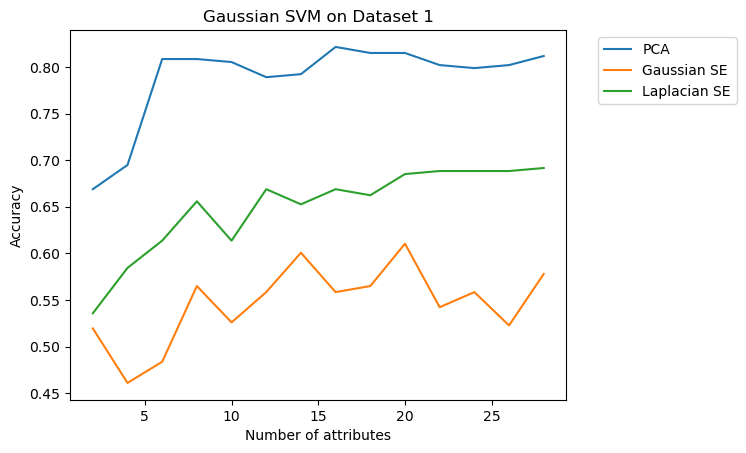

In [22]:
pca, se1, se2 = 0,0,0
max0, max1, max2 = 0,0,0
for i in All:
    subAll = All[i]
    if pca < subAll[0][0]:
        pca = subAll[0][0]
        max0 = i
    if se1 < subAll[1][0]:
        se1 = subAll[1][0]
        max1 = i
    if se2 < subAll[2][0]:
        se2 = subAll[2][0]
        max2 = i
print(f'Best accuracy: \n\tPCA accuracy = {pca} n_component = {max0}')
print(f'\tSE rbf accuracy = {se1} n_component = {max1}')
print(f'\tSE NN  accuracy = {se2} n_component = {max2}')

# -------------------------------------------------------------------
r0, r1,r2,r3 = [],[],[],[]
for sim in All:
    r0.append(sim)
    r1.append(All[sim][0][0])
    r2.append(All[sim][1][0])
    r3.append(All[sim][2][0])
# -------------------------------------------------------------------
fdf = pd.DataFrame({'Number of attributes': r0, 
                    'PCA':r1, 
                    'Gaussian SE': r2,
                    'Laplacian SE': r3})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['PCA', 'Gaussian SE', 'Laplacian SE'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title("Gaussian SVM on Dataset 1")
plt.show()

In [12]:
# -------------------------------------------------------------------
predictors = [Logistic, CART, kNN]
predictorsTXT = ['Logistic', 'CART', 'kNN']
# -------------------------------------------------------------------
def PCA_model(X, y=None, n = 2, nn=None):
#     print("PCA model")
    pca = PCA(n_components=16)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

def CE_Model(X, y=None, n=2, nn=10):
#     radial basis function
    sigma = 0.1
    embedding_gaussian = SpectralEmbedding(n_components=24, affinity='rbf', n_neighbors=nn, gamma=1 / (2 * sigma ** 2))
    X_CE = embedding_gaussian.fit_transform(X)
    return X_CE

def CE2(X, y=None, n=2, nn=10):
    embedding = SpectralEmbedding(n_components=28, affinity='nearest_neighbors', n_neighbors=nn, eigen_solver='arpack')
    X_CE = embedding.fit_transform(X)
    return X_CE
# -------------------------------------------------------------------
DR = [ PCA_model, CE_Model, CE2]
DR_TXT = [ 'PCA_model', 'CE_Model', 'CE2']
# -------------------------------------------------------------------
print(X1.shape)
All = {}
performance = []
for nn in range (2,30, 2): # Number of features
    X1s = [d(X1, np.ravel(Y1), _, nn) for d in DR] # dimension reduction
    results1 = [predict(x1, np.ravel(Y1), predictors)[0] for x1 in X1s] # Machine learning models
    
    All[nn] = results1
    

print('complete.....\n\n')

(1025, 30)


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification

D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification

D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

complete.....




D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Documents\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

In [13]:
All

{2: [(0.8214285714285714, 0.8228230129585075, 0.8228230129585075),
  (0.5162337662337663, 0.5215271622134988, 0.5215271622134988),
  (0.538961038961039, 0.5412181841205521, 0.5412181841205521)],
 4: [(0.8214285714285714, 0.8228230129585075, 0.8228230129585075),
  (0.5681818181818182, 0.5737410831117302, 0.5737410831117302),
  (0.5551948051948052, 0.5569414545608037, 0.5569414545608037)],
 6: [(0.8214285714285714, 0.8228230129585075, 0.8228230129585075),
  (0.44805194805194803, 0.45021316111603565, 0.45021316111603565),
  (0.5746753246753247, 0.5749651766493605, 0.5749651766493605)],
 8: [(0.8214285714285714, 0.8228230129585075, 0.8228230129585075),
  (0.5357142857142857, 0.5387066818623105, 0.5387066818623105),
  (0.6915584415584416, 0.6921826854079608, 0.6921826854079608)],
 10: [(0.8214285714285714, 0.8228230129585075, 0.8228230129585075),
  (0.5194805194805194, 0.5217171077624414, 0.5217171077624414),
  (0.6915584415584416, 0.6909163817483432, 0.6909163817483432)],
 12: [(0.82142857

In [14]:
pca, se1, se2 = 0,0,0
max0, max1, max2 = 0,0,0
for i in All:
    subAll = All[i]
    if pca < subAll[0][0]:
        pca = subAll[0][0]
        max0 = i
    if se1 < subAll[1][0]:
        se1 = subAll[1][0]
        max1 = i
    if se2 < subAll[2][0]:
        se2 = subAll[2][0]
        max2 = i
print(f'Best accuracy: \n\tPCA accuracy = {pca} n_component = {max0}')
print(f'\tSE rbf accuracy = {se1} n_component = {max1}')
print(f'\tSE NN  accuracy = {se2} n_component = {max2}')

Best accuracy: 
	PCA accuracy = 0.8214285714285714 n_component = 2
	SE rbf accuracy = 0.6201298701298701 n_component = 18
	SE NN  accuracy = 0.6915584415584416 n_component = 8


In [15]:
print(X2.shape)
NoF = 26 # Number of features

X2s = [d(X2, np.ravel(Y2), NoF) for d in DR]

results2 = [predict(x2, np.ravel(Y2), [Logistic]) for x2 in X2s]
finals = []
for i in range(len(DR)):
    rd = DR_TXT[i]
    acc, sen, spe = [],[],[]
    for a, s, e in results2[i]:
        acc.append(a)
        sen.append(s)
        spe.append(e)
    finals.append(pd.DataFrame({'model': ['Logistic'],'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))
    
    
finalR = {}
for i in ['Logistic']:
    D = pd.DataFrame() # create an empty DataFrame to hold the filtered rows     
    for df in finals:
        row = df[df['model'] == i]
        D = D.append(row) # filter rows that match a certain condition and append them to D
    D['DR'] = DR_TXT
    D = D.drop('model', axis=1)
    finalR[i] = D

for i in finalR:
    print(i)
    print(finalR[i][['DR', 'accuracy' , 'sensitivity',  'specificity']])
    print()

(2126, 36)


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Logistic
          DR  accuracy  sensitivity  specificity
0  PCA_model  0.934169     0.887175     0.955809
0   CE_Model  0.775862     0.332661     0.666108
0        CE2  0.780564     0.345191     0.679995



In [16]:
print(X2.shape)
All = {}
for NoF in range (2, X2.shape[1], 2): # Number of features
    X1s = [d(X2, np.ravel(Y2), NoF) for d in DR] # dimension reduction
    results1 = [predict(x, np.ravel(Y2), [Logistic])[0] for x in X1s] # Machine learning models
    All[NoF] = results1
    

print('complete.....\n\n')

(2126, 36)


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\skle

complete.....




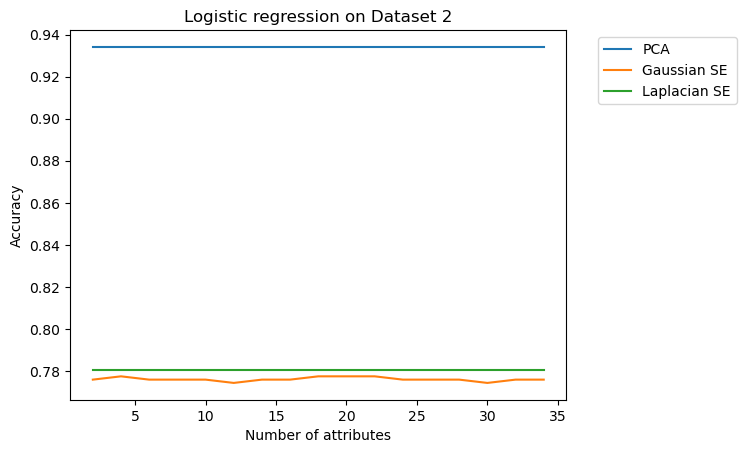

In [17]:
r0, r1,r2,r3 = [],[],[],[]
for sim in All:
    r0.append(sim)
    r1.append(All[sim][0][0])
    r2.append(All[sim][1][0])
    r3.append(All[sim][2][0])
#     r5.append(All[sim][4][0])
#     r6.append(All[sim][5][0])
#     r7.append(All[sim][6][0])
#     r8.append(All[sim][7][0])

fdf = pd.DataFrame({'Number of attributes': r0, 
                    'PCA':r1, 
                    'Gaussian SE': r2,
                    'Laplacian SE': r3})

import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['PCA', 'Gaussian SE', 'Laplacian SE'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title("Logistic regression on Dataset 2")
plt.show()
